In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../Data/selected_data/merged_data.csv')
data.info()

C:\Users\kaush\AppData\Local\Temp\ipykernel_27784\1736518648.py:6: DtypeWarning: Columns (33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../Data/selected_data/merged_data.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217242 entries, 0 to 217241
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           217242 non-null  int64  
 1   batter               217242 non-null  object 
 2   bowler               217242 non-null  object 
 3   non_striker          217242 non-null  object 
 4   runs_by_bat          217242 non-null  int64  
 5   extra_runs           217242 non-null  int64  
 6   total_runs_delivery  217242 non-null  int64  
 7   current_team_total   217242 non-null  int64  
 8   runs_remain          103118 non-null  float64
 9   batter_runs          217242 non-null  int64  
 10  balls_faced          217242 non-null  int64  
 11  wickets_fallen       217242 non-null  int64  
 12  extra_type           217242 non-null  object 
 13  delivery             217242 non-null  float64
 14  over                 217242 non-null  int64  
 15  wicket_type      

Selecting Player "KM Mendis"

In [2]:
sl_batsmen = data[data['batting_team'] == "Sri Lanka"]['batter'].unique()
sl_batsmen

array(['N Dickwella', 'WU Tharanga', 'EMDY Munaweera', 'DAS Gunaratne',
       'TAM Siriwardana', 'CK Kapugedera', 'S Prasanna', 'BKG Mendis',
       'KMDN Kulasekara', 'SL Malinga', 'MD Shanaka', 'JRMVB Sanjaya',
       'MDKJ Perera', 'NLTC Perera', 'AD Mathews', 'SMA Priyanjan',
       'I Udana', 'MD Gunathilaka', 'S Samarawickrama', 'ML Udawatte',
       'SS Pathirana', 'PC de Silva', 'A Dananjaya', 'PVD Chameera',
       'MVT Fernando', 'N Pradeep', 'LD Chandimal', 'BMAJ Mendis',
       'RAS Lakmal', 'DM de Silva', 'PHKD Mendis', 'MA Aponso',
       'PADLR Sandakan', 'WIA Fernando', 'AK Perera', 'CAK Rajitha',
       'CBRLS Kumara', 'PBB Rajapaksa', 'BOP Fernando', 'PWH de Silva',
       'GSNFG Jayasuriya', 'LD Madushanka', 'M Bhanuka', 'B Fernando',
       'P Nissanka', 'KNA Bandara', 'KIC Asalanka', 'C Karunaratne',
       'RTM Mendis', 'M Theekshana', 'JDF Vandersay', 'K Mishara',
       'J Liyanage', 'P Jayawickrama', 'N Thushara', 'PM Liyanagamage',
       'D Madushanka', 'M P

In [41]:
def getPlayerScores(player_name: str, innings: list[int] = [1, 2] ) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (data['innings'].isin(innings))
	]

	player_data.head()

	# 3 matches missing from the data
	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = [ 'batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	player_scores= gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery', 'wickets_fallen']]
	first_ball['first_ball'] = (first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']

	# when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker'] == player_name].index
	
	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, ['batter_runs', 'balls_faced']] = [0, 0]
	
	
	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]	
	
	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)
	
	



	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)
	return player_scores

In [42]:
getPlayerScores('BKG Mendis')

,batter,non_striker,batter_runs,balls_faced,wicket_type,won,innings,wickets_fallen,first_ball,strike_rate,out,last_ball
match_id,,,,,,,,,,,,
Afghanistan_Sri Lanka_2022-09-03,BKG Mendis,P Nissanka,36,19,caught,1.0,2,0,1,189.47,True,39
Afghanistan_Sri Lanka_2022-11-01,BKG Mendis,DM de Silva,25,29,caught,1.0,2,0,1,86.21,True,47
Afghanistan_Sri Lanka_2024-02-21,BKG Mendis,P Nissanka,16,14,caught,0.0,2,0,1,114.29,True,35
Australia_Sri Lanka_2017-02-19,BKG Mendis,EMDY Munaweera,5,7,caught,1.0,2,2,15,71.43,True,21
Australia_Sri Lanka_2017-02-22,BKG Mendis,EMDY Munaweera,14,10,caught,0.0,2,1,23,140.00,True,45
...,...,...,...,...,...,...,...,...,...,...,...,...
Sri Lanka_West Indies_2020-03-04,BKG Mendis,MDKJ Perera,0,3,caught,0.0,2,2,11,0.00,True,12
Sri Lanka_West Indies_2020-03-06,BKG Mendis,AD Mathews,11,13,caught,0.0,1,3,40,84.62,True,68
Sri Lanka_Zimbabwe_2024-01-16,BKG Mendis,S Samarawickrama,4,5,caught,0.0,1,0,1,80.00,True,22


# Analysis

## No of runs scored vs Win Percentage

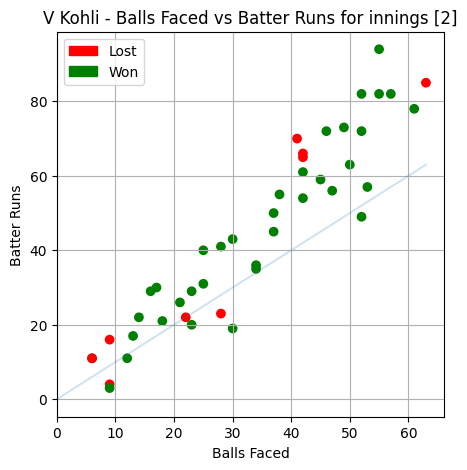

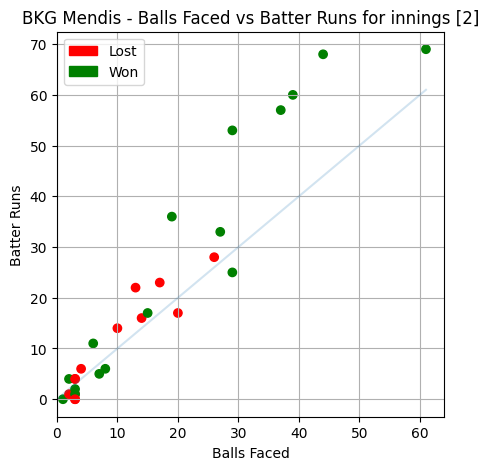

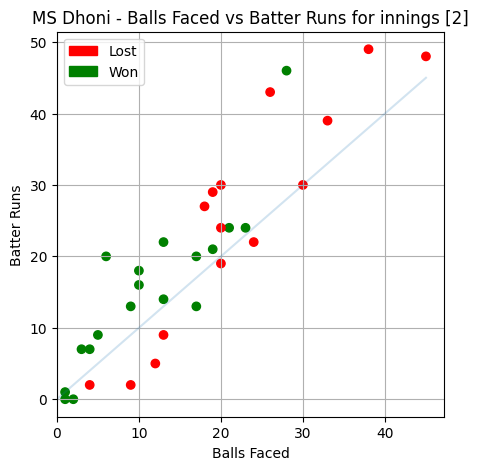

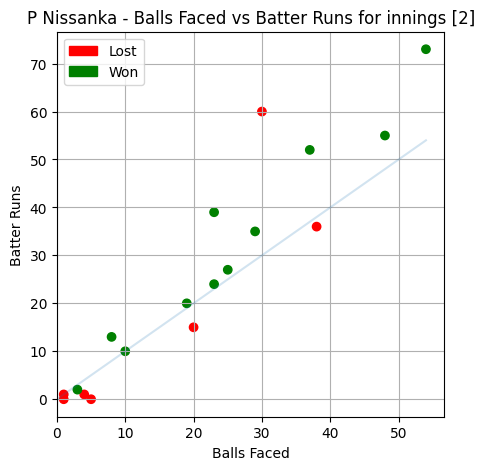

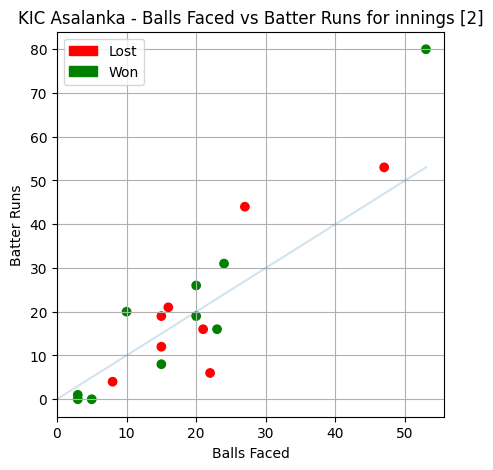

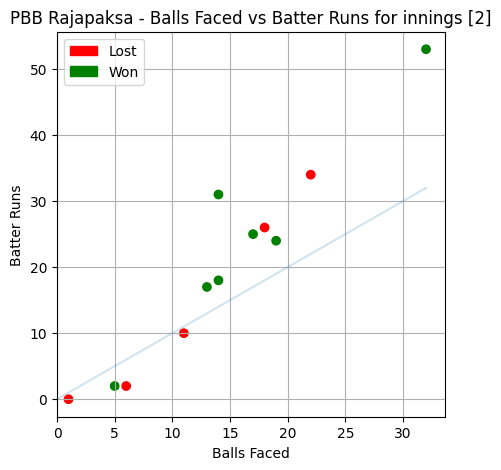

In [54]:
# Plotting win vs loss for runs scored by kusal mendis
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def showScatterBallsVRunsForWins(player_name: str, innings: list[int] = [1, 2], wickets: int = 11)-> None:

	player_scores = getPlayerScores(player_name, innings)
	# y axis runs scored
	# x axis balls faced
	# color - win or loss status
	if wickets != 11:
		player_scores = player_scores[player_scores['wickets_fallen'] == wickets]

	plt.figure(figsize=(5, 5))
	plt.scatter(player_scores["balls_faced"], +
				player_scores["batter_runs"],
				c=['red' if val == 0 else 'green' for val in player_scores['won']],
				
				)

	# 100 SR Line
	if not player_scores['balls_faced'].empty:
		x = np.linspace(0.0, max(player_scores['balls_faced']) , 100)  
		y = x
		plt.plot(x, y, alpha = 0.2)

	# Add legend with markers and labels
	red_patch = mpatches.Patch(color='red', label='Lost')
	green_patch = mpatches.Patch(color='green', label='Won')
	plt.xlim(xmin=0)
	plt.axes
	plt.legend(handles=[red_patch, green_patch])
	plt.xlabel("Balls Faced")
	plt.ylabel("Batter Runs")
	plt.title(f"{player_name} - Balls Faced vs Batter Runs for innings {innings}")
	plt.grid(True)

	plt.show()

players = ['V Kohli', 'BKG Mendis', 'MS Dhoni', 'P Nissanka', 'KIC Asalanka', 'PBB Rajapaksa']
for player in players:
	showScatterBallsVRunsForWins(player, innings = [2])

## First Ball Faced vs runs scored

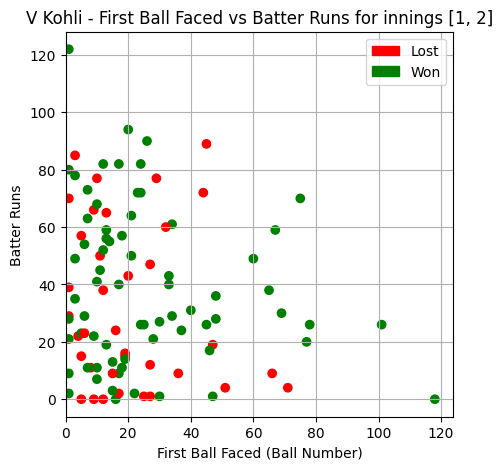

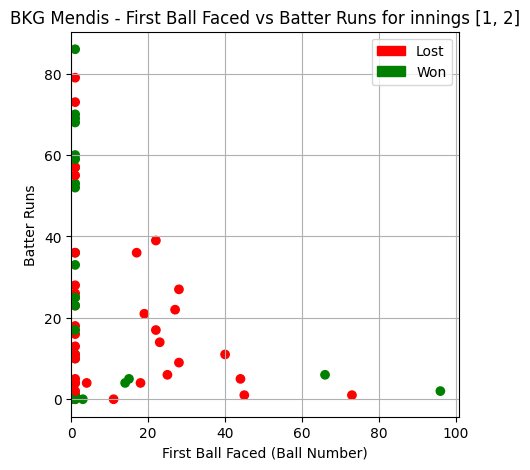

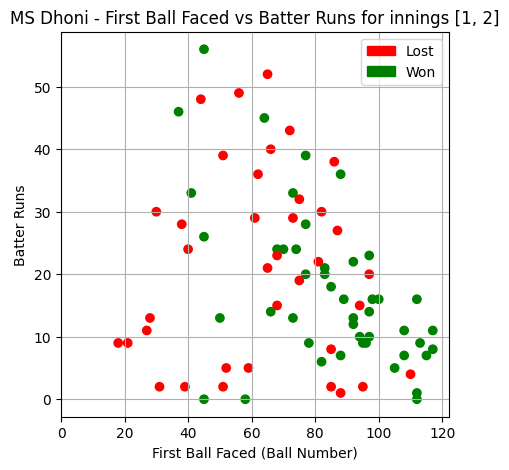

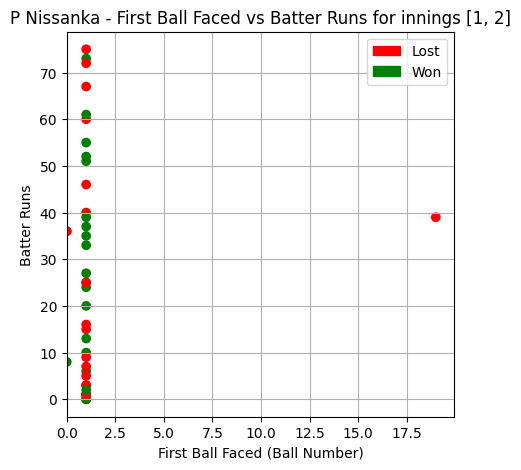

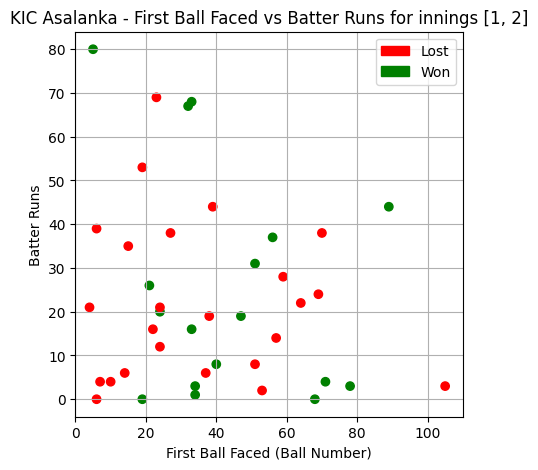

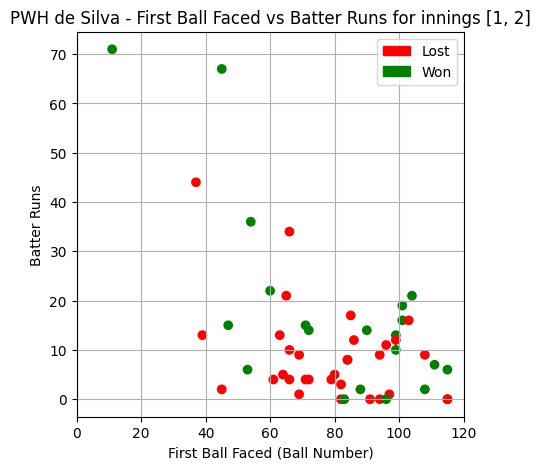

In [46]:
def showScatterFirstBallvsRunsScored(player_name: str, innings: list[int] = [1, 2])-> None:

	player_scores = getPlayerScores(player_name, innings)
	# y axis runs scored
	# x axis balls faced
	# color - win or loss status

	plt.figure(figsize=(5, 5))
	plt.scatter(player_scores["first_ball"], +
				player_scores["batter_runs"],
				c=['red' if val == 0 else 'green' for val in player_scores['won']],
				
				)

	# Add legend with markers and labels
	red_patch = mpatches.Patch(color='red', label='Lost')
	green_patch = mpatches.Patch(color='green', label='Won')
	plt.xlim(xmin=0)
	plt.axes
	plt.legend(handles=[red_patch, green_patch])
	plt.xlabel("First Ball Faced (Ball Number)")
	plt.ylabel("Batter Runs")
	plt.title(f"{player_name} - First Ball Faced vs Batter Runs for innings {innings}")
	plt.grid(True)

	plt.show()

players = ['V Kohli', 'BKG Mendis', 'MS Dhoni', 'P Nissanka', 'KIC Asalanka', 'PWH de Silva']
for player in players:
	showScatterFirstBallvsRunsScored(player, innings = [1, 2])

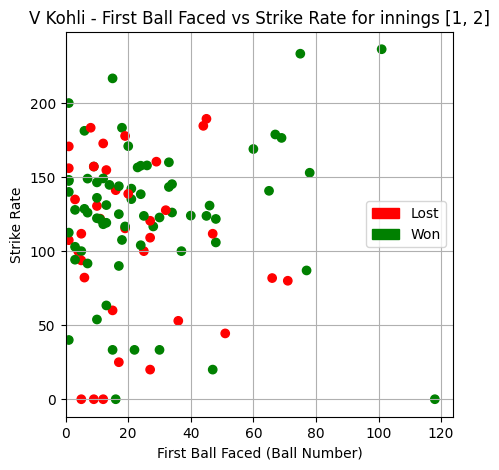

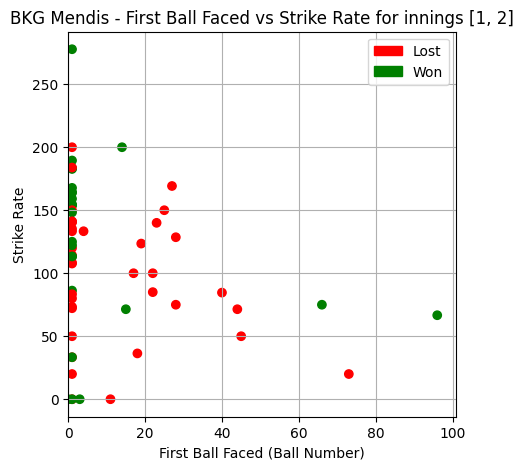

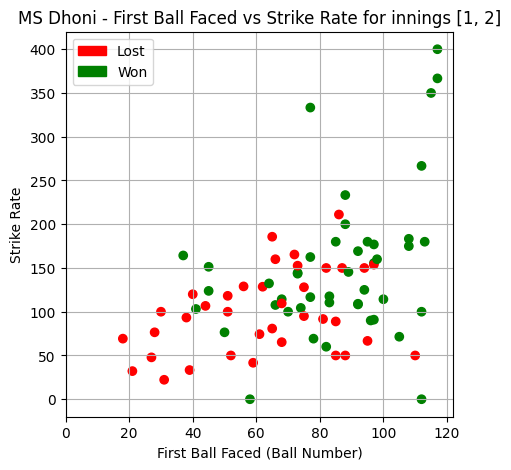

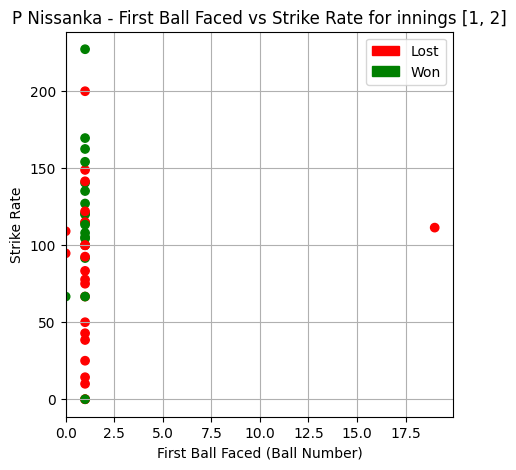

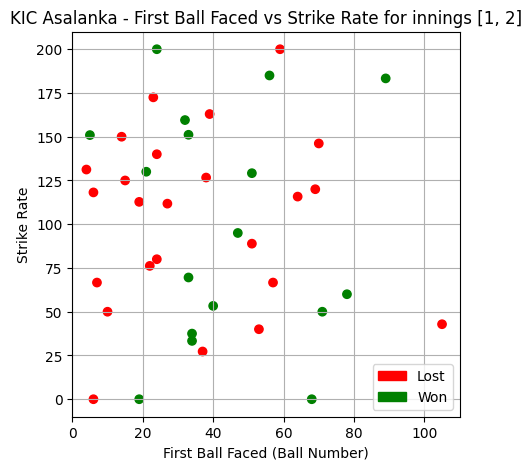

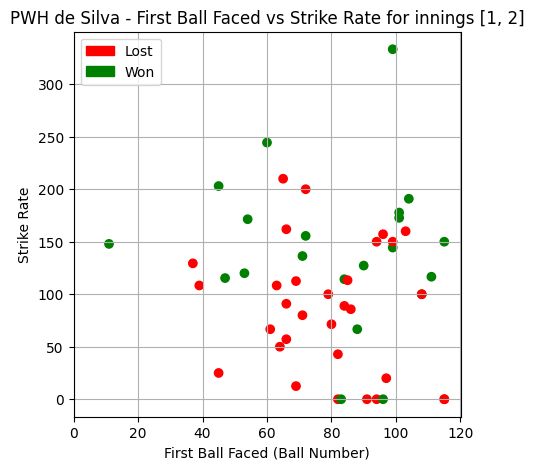

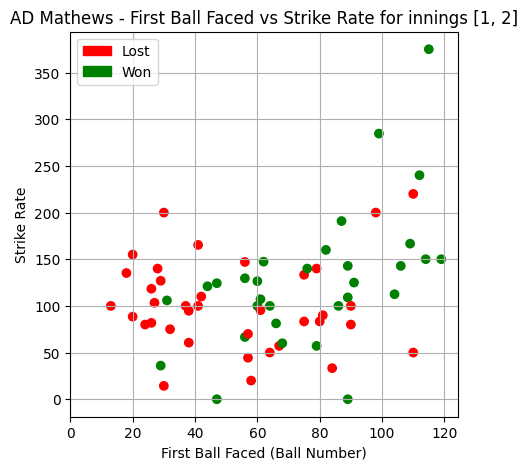

In [50]:
def showScatterFirstBallvsStrikeRate(player_name: str, innings: list[int] = [1, 2])-> None:

	player_scores = getPlayerScores(player_name, innings)
	# y axis runs scored
	# x axis balls faced
	# color - win or loss status

	plt.figure(figsize=(5, 5))
	plt.scatter(player_scores["first_ball"], +
				player_scores["strike_rate"],
				c=['red' if val == 0 else 'green' for val in player_scores['won']],
				
				)

	# Add legend with markers and labels
	red_patch = mpatches.Patch(color='red', label='Lost')
	green_patch = mpatches.Patch(color='green', label='Won')
	plt.xlim(xmin=0)
	plt.axes
	plt.legend(handles=[red_patch, green_patch])
	plt.xlabel("First Ball Faced (Ball Number)")
	plt.ylabel("Strike Rate")
	plt.title(f"{player_name} - First Ball Faced vs Strike Rate for innings {innings}")
	plt.grid(True)

	plt.show()

players = ['V Kohli', 'BKG Mendis', 'MS Dhoni', 'P Nissanka', 'KIC Asalanka', 'PWH de Silva', 'AD Mathews']
for player in players:
	showScatterFirstBallvsStrikeRate(player, innings = [1, 2])

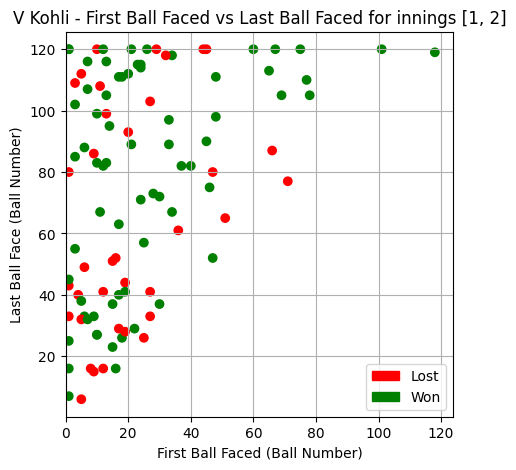

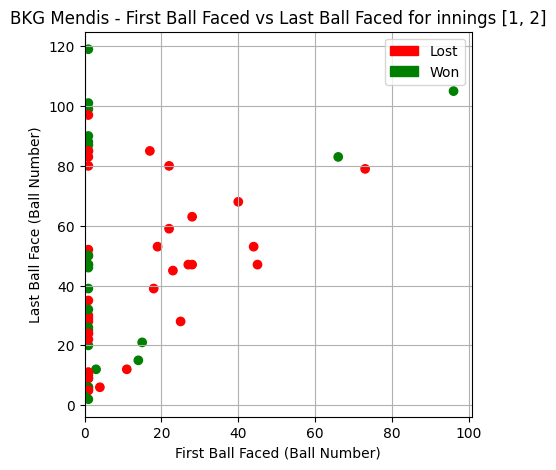

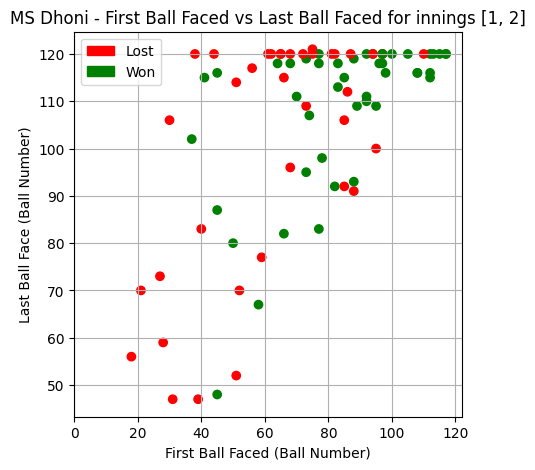

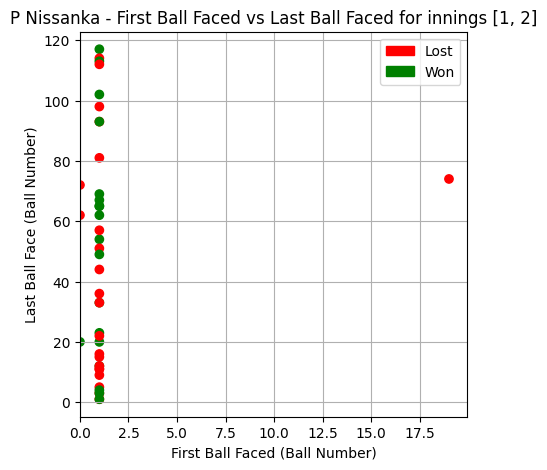

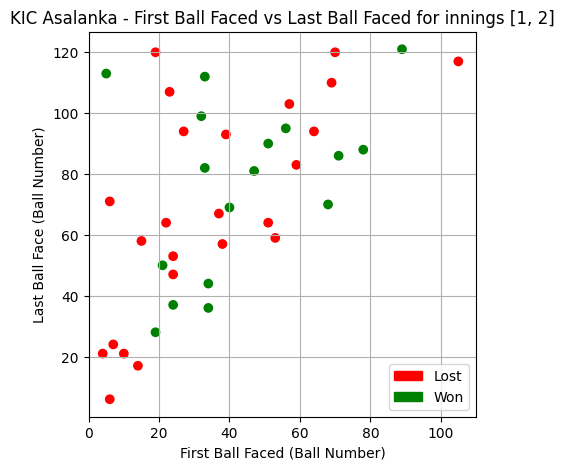

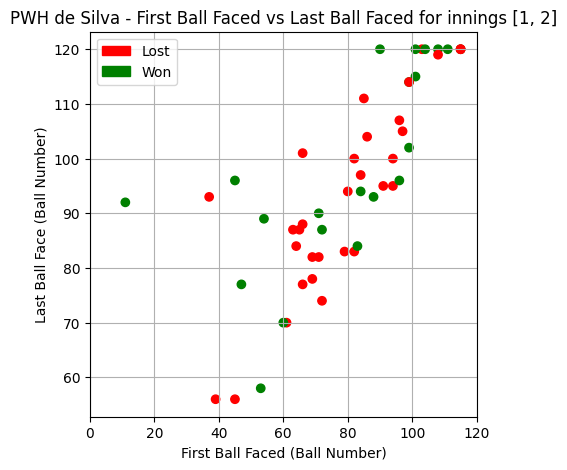

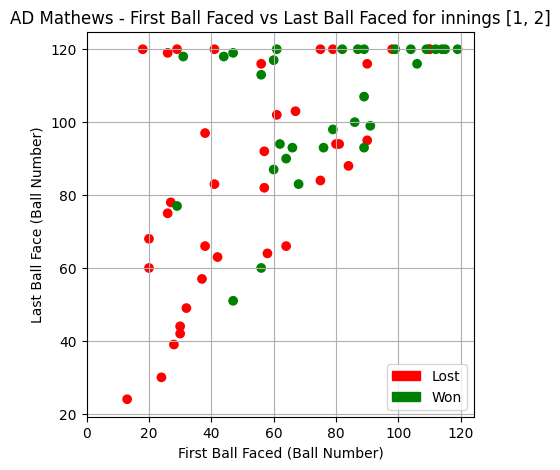

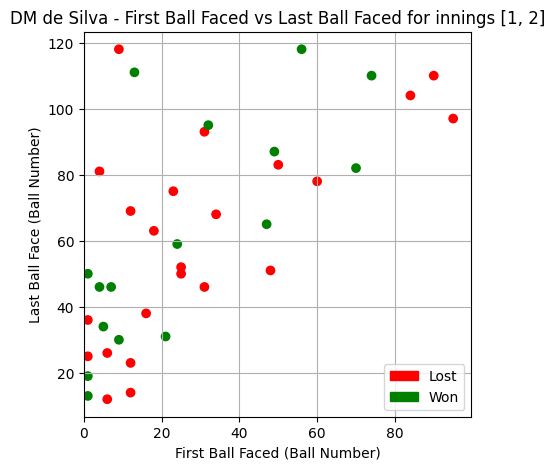

In [52]:
def showScatterFirstBallvsLastBall(player_name: str, innings: list[int] = [1, 2])-> None:

	player_scores = getPlayerScores(player_name, innings)
	# y axis runs scored
	# x axis balls faced
	# color - win or loss status

	plt.figure(figsize=(5, 5))
	plt.scatter(player_scores["first_ball"], +
				player_scores["last_ball"],
				c=['red' if val == 0 else 'green' for val in player_scores['won']],
				
				)

	# Add legend with markers and labels
	red_patch = mpatches.Patch(color='red', label='Lost')
	green_patch = mpatches.Patch(color='green', label='Won')
	plt.xlim(xmin=0)
	plt.axes
	plt.legend(handles=[red_patch, green_patch])
	plt.xlabel("First Ball Faced (Ball Number)")
	plt.ylabel("Last Ball Face (Ball Number)")
	plt.title(f"{player_name} - First Ball Faced vs Last Ball Faced for innings {innings}")
	plt.grid(True)

	plt.show()

players = ['V Kohli', 'BKG Mendis', 'MS Dhoni', 'P Nissanka', 'KIC Asalanka', 'PWH de Silva', 'AD Mathews', 'DM de Silva']
for player in players:
	showScatterFirstBallvsLastBall(player, innings = [1, 2])